In [29]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import os

In [30]:
os.chdir("/Users/st022/OneDrive/Documents/Carnegie_Mellon/Spring2025/optim/workdir2/PSO-for-NNs")
os.getcwd()

'c:\\Users\\st022\\OneDrive\\Documents\\Carnegie_Mellon\\Spring2025\\optim\\workdir2\\PSO-for-NNs'

# Hyperparameter Sensitivity Study

In [31]:
from models.mlp import MLP
from trainers.train_pso_hp import train_pso
from data.data import load_ucidata

In [32]:
train_loader, test_loader, inp_dim, out_dim = load_ucidata("wine")
loss = torch.nn.CrossEntropyLoss()

In [33]:
def run_particle_experiment(particle_counts, num_runs=3):
    train_loader, test_loader, inp_dim, out_dim = load_ucidata("wine")
    
    # Store all results
    all_results = []
    
    for run in range(num_runs):
        run_results = {}
        
        for count in particle_counts:
            print(f"\nRun {run+1}/{num_runs} | Particles: {count}")
            
            # Initialize model
            model = MLP(inp_dim, [32], out_dim)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            
            # Run PPSO
            start_time = time.time()
            results = train_pso(
                model=model,
                train_loader=train_loader,
                criterion=loss,
                variant="PPSO",
                num_particles=count,
                num_iterations=100,
                plot_convergence=False,
                val_loader=test_loader,
                early_stopping_patience=15,
                run_id=f"Run{run}_P{count}"
            )
            training_time = time.time() - start_time
            
            # Store results
            run_results[count] = {
                'train_loss': results['metrics']['train_loss'],
                'val_accuracy': results['metrics']['val_accuracy'],
                'time': training_time,
                'final_val_acc': max(results['metrics']['val_accuracy'])
            }
        
        all_results.append(run_results)
    
    return all_results

In [34]:
def plot_particle_results(all_results, particle_counts):
    plt.figure(figsize=(15, 15))
    
    # Plot 1: Training Loss Convergence
    plt.subplot(3, 1, 1)
    for count in particle_counts:
        # Find the minimum length across all runs
        min_length = min(len(r[count]['train_loss']) for r in all_results)
        # Truncate all sequences to this length and average
        truncated_losses = [r[count]['train_loss'][:min_length] for r in all_results]
        avg_loss = np.mean(truncated_losses, axis=0)
        std_loss = np.std(truncated_losses, axis=0)
        
        plt.plot(avg_loss, label=f'{count} particles')
        # plt.fill_between(range(min_length), 
        #                 avg_loss - std_loss, 
        #                 avg_loss + std_loss,
        #                 alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    plt.title('Training Loss by Particle Count')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Validation Accuracy Convergence
    plt.subplot(3, 1, 2)
    for count in particle_counts:
        min_length = min(len(r[count]['val_accuracy']) for r in all_results)
        truncated_accs = [r[count]['val_accuracy'][:min_length] for r in all_results]
        avg_acc = np.mean(truncated_accs, axis=0)
        std_acc = np.std(truncated_accs, axis=0)
        
        plt.plot(avg_acc, label=f'{count} particles')
        # plt.fill_between(range(min_length),
        #                avg_acc - std_acc,
        #                avg_acc + std_acc,
        #                alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Particle Count')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Final Performance vs Time
    plt.subplot(3, 1, 3)
    final_accs = [np.mean([r[count]['final_val_acc'] for r in all_results]) 
                 for count in particle_counts]
    acc_stds = [np.std([r[count]['final_val_acc'] for r in all_results])
               for count in particle_counts]
    times = [np.mean([r[count]['time'] for r in all_results])
            for count in particle_counts]
    time_stds = [np.std([r[count]['time'] for r in all_results])
               for count in particle_counts]
    
    # Accuracy plot with error bars
    plt.errorbar(particle_counts, final_accs, yerr=acc_stds, 
                fmt='o-', capsize=5, label='Accuracy')
    plt.xlabel('Number of Particles')
    plt.ylabel('Final Validation Accuracy', color='blue')
    plt.tick_params(axis='y', labelcolor='blue')
    plt.grid(True)
    
    # Time plot with error bars
    ax2 = plt.gca().twinx()
    ax2.errorbar(particle_counts, times, yerr=time_stds,
                fmt='o--', color='orange', capsize=5, label='Time')
    ax2.set_ylabel('Training Time (s)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    plt.title('Performance vs Computational Cost')
    plt.tight_layout()
    plt.show()

    print("\nSummary of Results:")
    print("| Particles | Avg Val Acc | Std Dev | Avg Time (s) |")
    print("|-----------|-------------|---------|--------------|")
    for count in particle_counts:
        accs = [r[count]['final_val_acc'] for r in all_results]
        times = [r[count]['time'] for r in all_results]
        print(f"| {count:9} | {np.mean(accs):.4f}     | {np.std(accs):.4f}   | {np.mean(times):.2f}        |")

## Number of Particles


Run 1/8 | Particles: 4
[PPSO] Run Run0_P4 | Epoch 000: Train Loss = 1.2264, Acc = 0.6479 | Val Loss = 1.0498, Val Acc = 0.6389 (Best: 0.6389)
[PPSO] Run Run0_P4 | Epoch 025: Train Loss = 0.1728, Acc = 0.9507 | Val Loss = 0.1628, Val Acc = 0.9444 (Best: 0.9722)
Early stopping at epoch 30

Run 1/8 | Particles: 8
[PPSO] Run Run0_P8 | Epoch 000: Train Loss = 1.9237, Acc = 0.5352 | Val Loss = 2.5826, Val Acc = 0.5556 (Best: 0.5556)
[PPSO] Run Run0_P8 | Epoch 025: Train Loss = 0.0859, Acc = 0.9296 | Val Loss = 0.1716, Val Acc = 0.9444 (Best: 0.9722)
Early stopping at epoch 32

Run 1/8 | Particles: 16
[PPSO] Run Run0_P16 | Epoch 000: Train Loss = 0.9083, Acc = 0.3099 | Val Loss = 2.5122, Val Acc = 0.2500 (Best: 0.2500)
Early stopping at epoch 22

Run 1/8 | Particles: 32
[PPSO] Run Run0_P32 | Epoch 000: Train Loss = 0.7137, Acc = 0.4366 | Val Loss = 0.9416, Val Acc = 0.5000 (Best: 0.5000)
[PPSO] Run Run0_P32 | Epoch 025: Train Loss = 0.0309, Acc = 0.9577 | Val Loss = 0.0262, Val Acc = 1.0000 

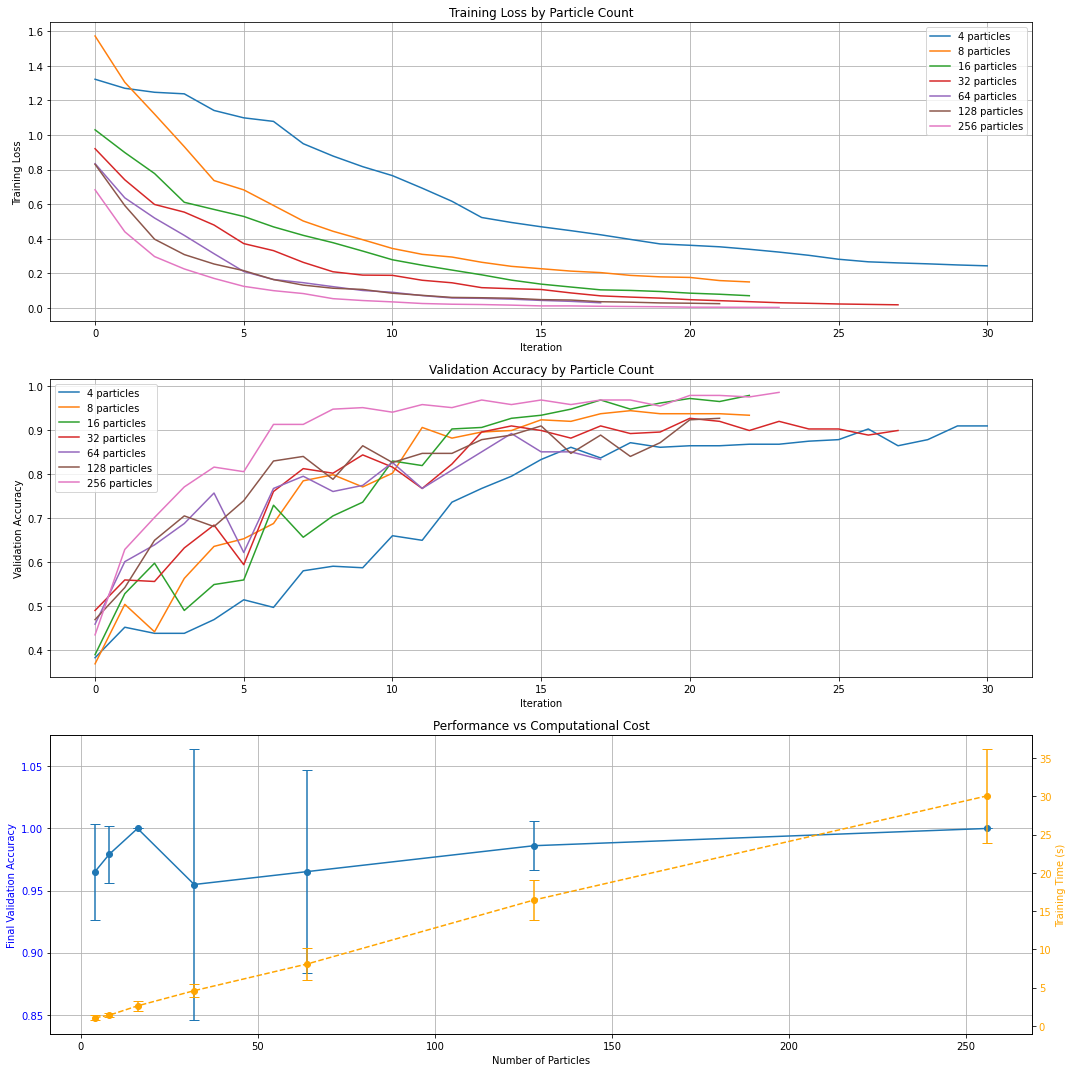


Summary of Results:
| Particles | Avg Val Acc | Std Dev | Avg Time (s) |
|-----------|-------------|---------|--------------|
|         4 | 0.9653     | 0.0387   | 1.06        |
|         8 | 0.9792     | 0.0230   | 1.39        |
|        16 | 1.0000     | 0.0000   | 2.62        |
|        32 | 0.9549     | 0.1093   | 4.60        |
|        64 | 0.9653     | 0.0819   | 8.10        |
|       128 | 0.9861     | 0.0196   | 16.45        |
|       256 | 1.0000     | 0.0000   | 30.06        |


In [35]:
particle_counts = [4, 8, 16, 32, 64, 128, 256]
all_results = run_particle_experiment(particle_counts, num_runs=8)
    
plot_particle_results(all_results, particle_counts)

    


# Cognitive Coefficient

In [36]:
def run_cog_exp(cog_coeffs, num_particles=50, num_runs=3):
    train_loader, test_loader, inp_dim, out_dim = load_ucidata("wine")

    all_results = []
    for run in range(num_runs):
        run_results = {}

        for cog in cog_coeffs:
            print(f"\nRun {run + 1} / {num_runs} | Cognitive Coeff: {cog}")

            model = MLP(inp_dim, [32], out_dim)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            config = {
                "cognitive_coeff": cog,
                "social_coeff": 1.7,
                "inertia_range": (0.4, 0.9),
                "use_sobol": True
            }

            start_time = time.time()
            results = train_pso(
                model,
                train_loader,
                criterion=loss,
                variant="PPSO",
                num_particles=num_particles,
                num_iterations=100,
                plot_convergence=False,
                val_loader=test_loader,
                early_stopping_patience=15,
                run_id=f"Run{run}_C{cog}",
                config=config
            )

            training_time = time.time() - start_time
            run_results[cog] = {
                'train_loss': results['metrics']['train_loss'],
                'val_accuracy': results['metrics']['val_accuracy'],
                'time': training_time,
                'final_val_acc': max(results['metrics']['val_accuracy'])
            }

        all_results.append(run_results)
    
    return all_results

In [37]:
def plot_cog_results(all_results, cog_coeffs):
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    for coeff in cog_coeffs:
        min_len = min(len(r[coeff]['train_loss']) for r in all_results)
        truncated_losses = [r[coeff]['train_loss'][:min_len] for r in all_results]
        avg_loss = np.mean(truncated_losses, axis=0)
        std_loss = np.std(truncated_losses, axis=0)

        plt.plot(avg_loss, label=f'{coeff} cognitive coeff')
        # plt.fill_between(range(min_len), 
        #                 avg_loss - std_loss, 
        #                 avg_loss + std_loss,
        #                 alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    plt.title('Training Loss by Cognitive Coeff\n(Fixed social=1.7)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    for coeff in cog_coeffs:
        min_length = min(len(r[coeff]['val_accuracy']) for r in all_results)
        truncated_accs = [r[coeff]['val_accuracy'][:min_length] for r in all_results]
        avg_acc = np.mean(truncated_accs, axis=0)
        std_acc = np.std(truncated_accs, axis=0)

        plt.plot(avg_acc, label=f'{coeff} cognitive coeff')
        # plt.fill_between(range(min_length),
        #                avg_acc - std_acc,
        #                avg_acc + std_acc,
        #                alpha=0.2)
        
    plt.xlabel('Iteration')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Cognitive Coeff\n(Fixed social=1.7)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    final_accs = [np.mean([r[coeff]['final_val_acc'] for r in all_results]) 
                 for coeff in cog_coeffs]
    acc_stds = [np.std([r[coeff]['final_val_acc'] for r in all_results])
                for coeff in cog_coeffs]
    plt.errorbar(cog_coeffs, final_accs, yerr=acc_stds, 
                 fmt='o-', capsize=5, label='Accuracy')
    plt.xlabel('Cognitive Coefficient')
    plt.ylabel('Final Validation Accuracy', color='blue')
    plt.title('Final Performance vs Cognitive Coeff\n(Fixed social=1.7)')
    plt.tick_params(axis='y', labelcolor='blue')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\nSummary of Results:")
    print("| Cog Coeff | Avg Val Acc | Std Dev | Avg Time (s) |")
    print("|-----------|-------------|---------|--------------|")
    for coeff in cog_coeffs:
        accs = [r[coeff]['final_val_acc'] for r in all_results]
        times = [r[coeff]['time'] for r in all_results]
        print(f"| {coeff:9} | {np.mean(accs):.4f}     | {np.std(accs):.4f}   | {np.mean(times):.2f}        |")


Run 1 / 8 | Cognitive Coeff: 0
[PPSO] Run Run0_C0 | Epoch 000: Train Loss = 0.6739, Acc = 0.3310 | Val Loss = 2.0900, Val Acc = 0.3611 (Best: 0.3611)
[PPSO] Run Run0_C0 | Epoch 025: Train Loss = 0.0026, Acc = 1.0000 | Val Loss = 0.0086, Val Acc = 1.0000 (Best: 1.0000)
Early stopping at epoch 32

Run 1 / 8 | Cognitive Coeff: 0.1
[PPSO] Run Run0_C0.1 | Epoch 000: Train Loss = 0.8937, Acc = 0.4859 | Val Loss = 1.0865, Val Acc = 0.5556 (Best: 0.5556)
Early stopping at epoch 24

Run 1 / 8 | Cognitive Coeff: 0.25
[PPSO] Run Run0_C0.25 | Epoch 000: Train Loss = 0.8490, Acc = 0.6338 | Val Loss = 1.1831, Val Acc = 0.5556 (Best: 0.5556)
Early stopping at epoch 24

Run 1 / 8 | Cognitive Coeff: 0.5
[PPSO] Run Run0_C0.5 | Epoch 000: Train Loss = 0.7879, Acc = 0.4577 | Val Loss = 1.5273, Val Acc = 0.4722 (Best: 0.4722)
[PPSO] Run Run0_C0.5 | Epoch 025: Train Loss = 0.0498, Acc = 0.9859 | Val Loss = 0.0669, Val Acc = 0.9722 (Best: 1.0000)
Early stopping at epoch 37

Run 1 / 8 | Cognitive Coeff: 1.0


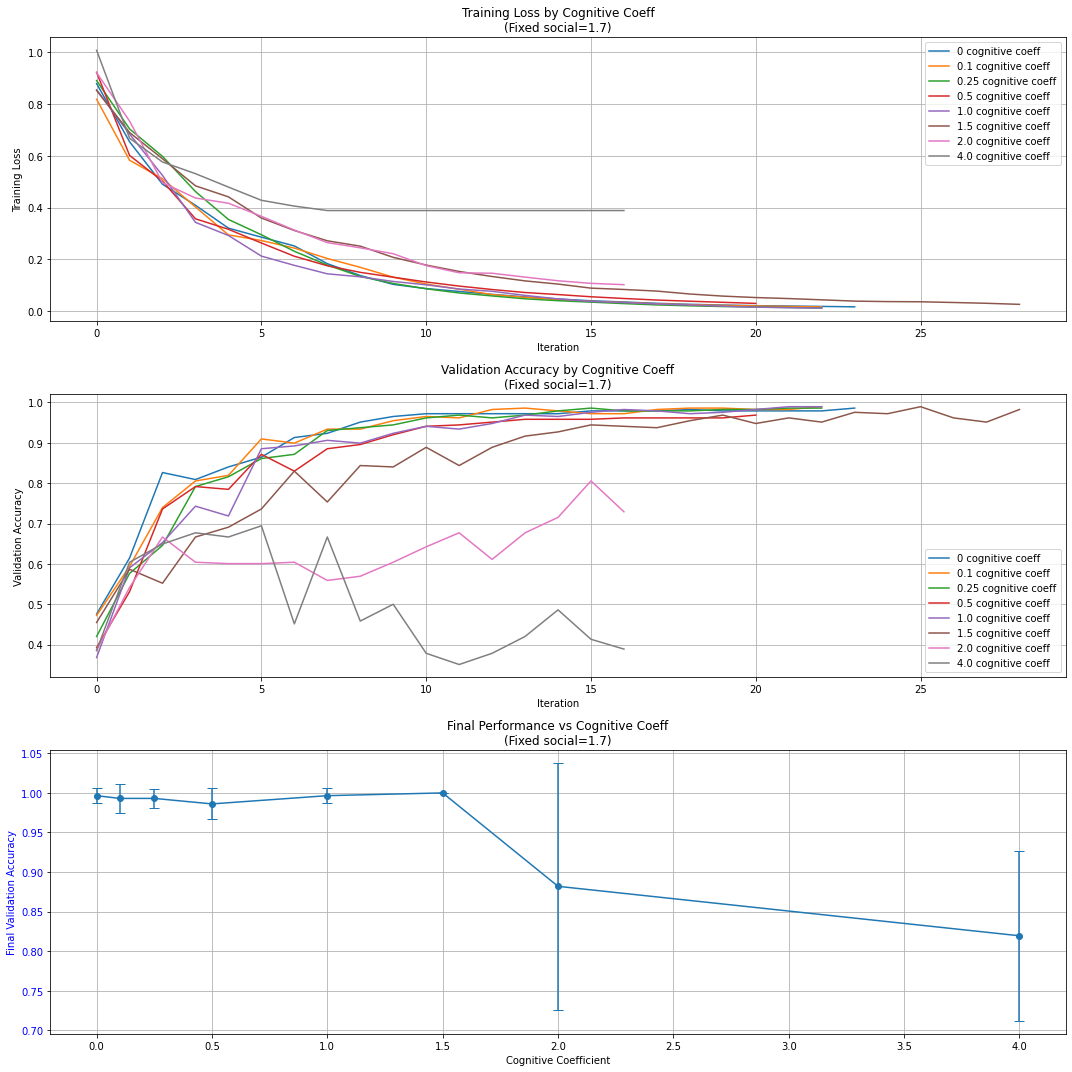


Summary of Results:
| Cog Coeff | Avg Val Acc | Std Dev | Avg Time (s) |
|-----------|-------------|---------|--------------|
|         0 | 0.9965     | 0.0092   | 6.31        |
|       0.1 | 0.9931     | 0.0184   | 6.56        |
|      0.25 | 0.9931     | 0.0120   | 6.97        |
|       0.5 | 0.9861     | 0.0196   | 7.85        |
|       1.0 | 0.9965     | 0.0092   | 7.07        |
|       1.5 | 1.0000     | 0.0000   | 7.81        |
|       2.0 | 0.8819     | 0.1557   | 6.82        |
|       4.0 | 0.8194     | 0.1076   | 4.73        |


In [38]:
cognitive_coeffs = [0, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 4.0]

# Run experiment (3 runs for each coefficient)
all_results = run_cog_exp(cognitive_coeffs, num_runs=8)

# Visualize results
plot_cog_results(all_results, cognitive_coeffs)


Run 1 / 8 | Cognitive Coeff: 0
[PPSO] Run Run0_C0 | Epoch 000: Train Loss = 0.6842, Acc = 0.5423 | Val Loss = 2.2529, Val Acc = 0.5556 (Best: 0.5556)
[PPSO] Run Run0_C0 | Epoch 025: Train Loss = 0.0597, Acc = 0.9859 | Val Loss = 0.0431, Val Acc = 0.9722 (Best: 0.9722)
Early stopping at epoch 28

Run 1 / 8 | Cognitive Coeff: 0.0001
[PPSO] Run Run0_C0.0001 | Epoch 000: Train Loss = 0.9211, Acc = 0.5845 | Val Loss = 0.6920, Val Acc = 0.7222 (Best: 0.7222)
[PPSO] Run Run0_C0.0001 | Epoch 025: Train Loss = 0.0180, Acc = 1.0000 | Val Loss = 0.0080, Val Acc = 1.0000 (Best: 1.0000)
Early stopping at epoch 29

Run 1 / 8 | Cognitive Coeff: 0.001
[PPSO] Run Run0_C0.001 | Epoch 000: Train Loss = 0.8237, Acc = 0.3239 | Val Loss = 1.9380, Val Acc = 0.4167 (Best: 0.4167)
[PPSO] Run Run0_C0.001 | Epoch 025: Train Loss = 0.0066, Acc = 1.0000 | Val Loss = 0.2271, Val Acc = 0.9167 (Best: 0.9444)
Early stopping at epoch 41

Run 1 / 8 | Cognitive Coeff: 0.01
[PPSO] Run Run0_C0.01 | Epoch 000: Train Loss =

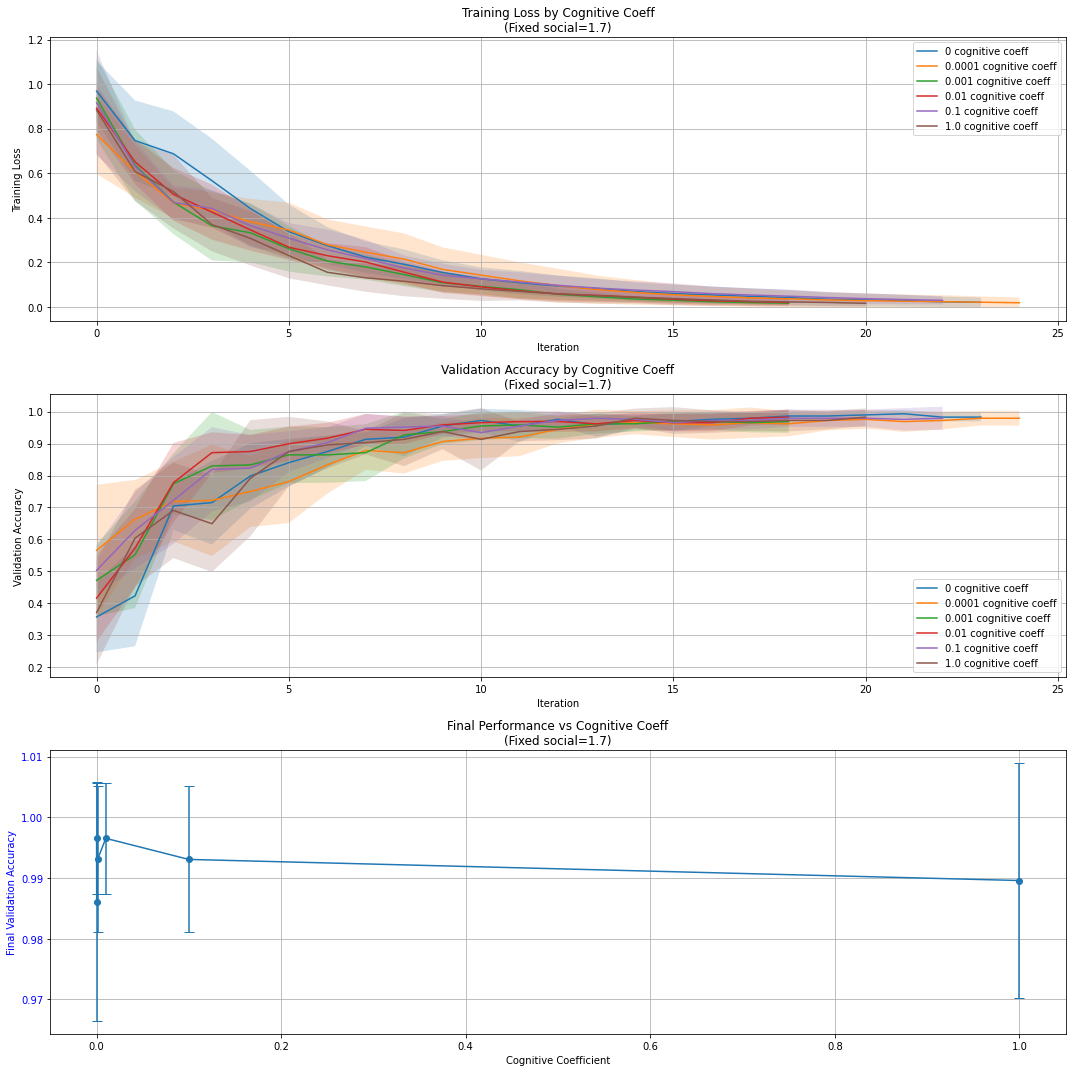


Summary of Results:
| Cog Coeff | Avg Val Acc | Std Dev | Avg Time (s) |
|-----------|-------------|---------|--------------|
|         0 | 0.9965     | 0.0092   | 8.96        |
|    0.0001 | 0.9861     | 0.0196   | 9.25        |
|     0.001 | 0.9931     | 0.0120   | 9.29        |
|      0.01 | 0.9965     | 0.0092   | 8.65        |
|       0.1 | 0.9931     | 0.0120   | 9.01        |
|       1.0 | 0.9896     | 0.0193   | 8.37        |


In [18]:
cognitive_coeffs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]

# Run experiment (3 runs for each coefficient)
all_results = run_cog_exp(cognitive_coeffs, num_runs=8)

# Visualize results
plot_cog_results(all_results, cognitive_coeffs)

# Social Coefficient

In [19]:
def run_social_exp(social_coeffs, num_particles=50, num_runs=3):
    train_loader, test_loader, inp_dim, out_dim = load_ucidata("wine")

    all_results = []
    for run in range(num_runs):
        run_results = {}

        for social in social_coeffs:
            print(f"\nRun {run + 1} / {num_runs} | Social Coeff: {social}")

            model = MLP(inp_dim, [32], out_dim)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            config = {
                "cognitive_coeff": 1.6,
                "social_coeff": social,
                "inertia_range": (0.4, 0.9),
                "use_sobol": True
            }

            start_time = time.time()
            results = train_pso(
                model,
                train_loader,
                criterion=loss,
                variant="PPSO",
                num_particles=num_particles,
                num_iterations=100,
                plot_convergence=False,
                val_loader=test_loader,
                early_stopping_patience=15,
                run_id=f"Run{run}_S{social}",
                config=config
            )

            training_time = time.time() - start_time
            run_results[social] = {
                'train_loss': results['metrics']['train_loss'],
                'val_accuracy': results['metrics']['val_accuracy'],
                'time': training_time,
                'final_val_acc': max(results['metrics']['val_accuracy'])
            }

        all_results.append(run_results)
    
    return all_results


In [39]:
def plot_social_results(all_results, social_coeffs):
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    for coeff in social_coeffs:
        min_len = min(len(r[coeff]['train_loss']) for r in all_results)
        truncated_losses = [r[coeff]['train_loss'][:min_len] for r in all_results]
        avg_loss = np.mean(truncated_losses, axis=0)
        std_loss = np.std(truncated_losses, axis=0)

        plt.plot(avg_loss, label=f'{coeff} social coeff')
        # plt.fill_between(range(min_len), 
        #                 avg_loss - std_loss, 
        #                 avg_loss + std_loss,
        #                 alpha=0.2)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    plt.title('Training Loss by Social Coeff\n(Fixed cognitive=1.6)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    for coeff in social_coeffs:
        min_length = min(len(r[coeff]['val_accuracy']) for r in all_results)
        truncated_accs = [r[coeff]['val_accuracy'][:min_length] for r in all_results]
        avg_acc = np.mean(truncated_accs, axis=0)
        std_acc = np.std(truncated_accs, axis=0)

        plt.plot(avg_acc, label=f'{coeff} social coeff')
        # plt.fill_between(range(min_length),
        #                avg_acc - std_acc,
        #                avg_acc + std_acc,
        #                alpha=0.2)
        
    plt.xlabel('Iteration')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy by Social Coeff\n(Fixed cognitive=1.6)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    final_accs = [np.mean([r[coeff]['final_val_acc'] for r in all_results]) 
                 for coeff in social_coeffs]
    acc_stds = [np.std([r[coeff]['final_val_acc'] for r in all_results])
                for coeff in social_coeffs]
    plt.errorbar(social_coeffs, final_accs, yerr=acc_stds, 
                 fmt='o-', capsize=5, label='Accuracy')
    plt.xlabel('Social Coefficient')
    plt.ylabel('Final Validation Accuracy', color='blue')
    plt.title('Final Performance vs Social Coeff\n(Fixed cognitive=1.6)')
    plt.tick_params(axis='y', labelcolor='blue')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\nSummary of Results:")
    print("| Social Coeff | Avg Val Acc | Std Dev | Avg Time (s) |")
    print("|--------------|-------------|---------|--------------|")
    for coeff in social_coeffs:
        accs = [r[coeff]['final_val_acc'] for r in all_results]
        times = [r[coeff]['time'] for r in all_results]
        print(f"| {coeff:12} | {np.mean(accs):.4f}     | {np.std(accs):.4f}   | {np.mean(times):.2f}        |")


Run 1 / 3 | Social Coeff: 0
[PPSO] Run Run0_S0 | Epoch 000: Train Loss = 0.7846, Acc = 0.1338 | Val Loss = 1.9362, Val Acc = 0.2778 (Best: 0.2778)
Early stopping at epoch 15

Run 1 / 3 | Social Coeff: 0.01
[PPSO] Run Run0_S0.01 | Epoch 000: Train Loss = 1.2469, Acc = 0.3169 | Val Loss = 2.5707, Val Acc = 0.2778 (Best: 0.2778)
Early stopping at epoch 15

Run 1 / 3 | Social Coeff: 0.1
[PPSO] Run Run0_S0.1 | Epoch 000: Train Loss = 0.7853, Acc = 0.0423 | Val Loss = 3.5237, Val Acc = 0.0556 (Best: 0.0556)
[PPSO] Run Run0_S0.1 | Epoch 025: Train Loss = 0.6112, Acc = 0.7535 | Val Loss = 0.6688, Val Acc = 0.8333 (Best: 0.8333)
Early stopping at epoch 45

Run 1 / 3 | Social Coeff: 1.6
[PPSO] Run Run0_S1.6 | Epoch 000: Train Loss = 0.8345, Acc = 0.7113 | Val Loss = 0.6392, Val Acc = 0.6389 (Best: 0.6389)
[PPSO] Run Run0_S1.6 | Epoch 025: Train Loss = 0.0130, Acc = 0.9789 | Val Loss = 0.0144, Val Acc = 1.0000 (Best: 1.0000)
Early stopping at epoch 32

Run 1 / 3 | Social Coeff: 2.0
[PPSO] Run Ru

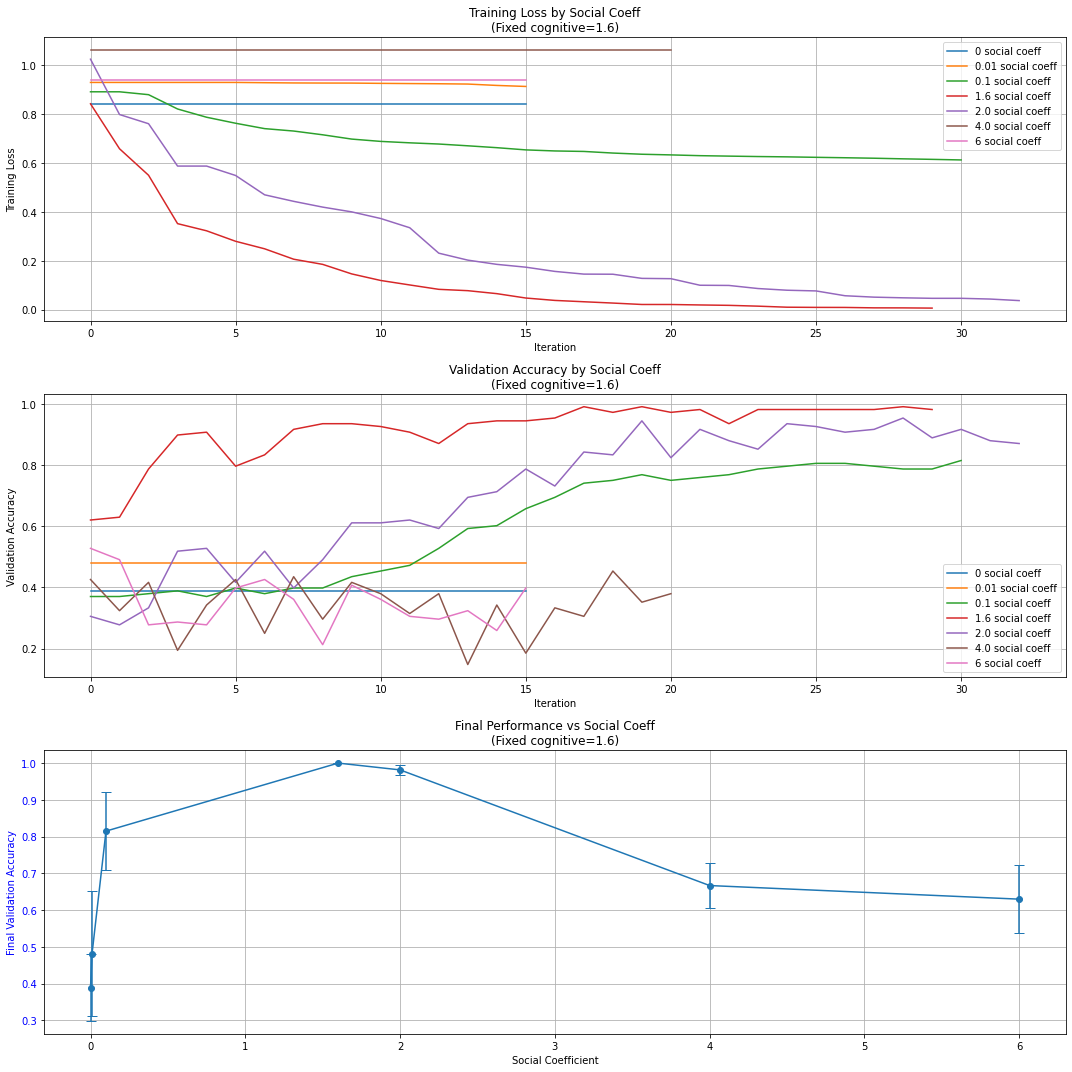


Summary of Results:
| Social Coeff | Avg Val Acc | Std Dev | Avg Time (s) |
|--------------|-------------|---------|--------------|
|            0 | 0.3889     | 0.0907   | 3.94        |
|         0.01 | 0.4815     | 0.1702   | 3.64        |
|          0.1 | 0.8148     | 0.1072   | 8.77        |
|          1.6 | 1.0000     | 0.0000   | 8.25        |
|          2.0 | 0.9815     | 0.0131   | 8.87        |
|          4.0 | 0.6667     | 0.0600   | 6.35        |
|            6 | 0.6296     | 0.0917   | 4.55        |


In [40]:
social_coeffs = [0, 1e-2, 1e-1, 1.6, 2.0, 4.0, 6]

all_results = run_social_exp(social_coeffs, num_runs=3)

plot_social_results(all_results, social_coeffs)